In [1]:
import level1,level2,analysis,plottools,inversions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import datetime as dt
import scipy.stats as stats
import numpy.ma as ma

In [3]:
# Data
eddies = np.load('eddies_last.npy').item()

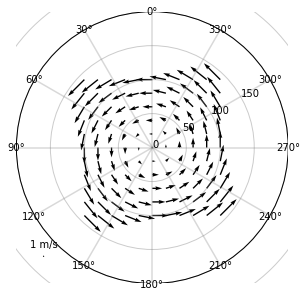

In [4]:
#simulate a whole eddy
xm = np.arange(-100000,101000,20000)
ym = np.arange(-100000,101000,20000)
X,Y = np.meshgrid(xm,ym)
xc = 0
yc = 0
U,V = inversions.Simulate(xc,yc,X,Y,omega=1e-5,fmt='UV')
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
plottools.Hodograph(ax,200,xtext=False,ytext=False,grid=50)
# Set axis limits, in order to see circle aspect MUST be set to equal
#ax.set_xlim(-200,200)
#ax.set_ylim(-200,200)
ax.set_aspect('equal')

Q=plt.quiver(xm/1000,ym/1000,U,V,width=0.005,pivot='tail')
plt.quiverkey(Q,0.1,0.1,0.01,label= '1 m/s')
plt.show()